In [1]:
#importing necessary libraries 
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import timm  # for EfficientNet-B4
import pandas as pd
import numpy as np

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
#dataset root
DATA_ROOT = "/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2"
META_PATH = os.path.join(DATA_ROOT, "meta_data.csv")

df = pd.read_csv(META_PATH)
print(df.head())
print("Total rows:", len(df))
df['method'].value_counts()
df['type'].value_counts()

    source target1 target2 method category                 type     race  \
0  id00076       -       -   real        A  RealVideo-RealAudio  African   
1  id00166       -       -   real        A  RealVideo-RealAudio  African   
2  id00173       -       -   real        A  RealVideo-RealAudio  African   
3  id00366       -       -   real        A  RealVideo-RealAudio  African   
4  id00391       -       -   real        A  RealVideo-RealAudio  African   

  gender       path                                         Unnamed: 9  
0    men  00109.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...  
1    men  00010.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...  
2    men  00118.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...  
3    men  00118.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...  
4    men  00052.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...  
Total rows: 21566


type
FakeVideo-FakeAudio    10857
FakeVideo-RealAudio     9709
RealVideo-FakeAudio      500
RealVideo-RealAudio      500
Name: count, dtype: int64

In [3]:
df.head(10)
df.shape

(21566, 10)

In [4]:



print(df.columns)

# — Fix column names (correct)
df = df.rename(columns={
    'path': 'filename',
    'Unnamed: 9': 'folder_path'
})

# Clean folder_path (remove "FakeAVCeleb/" prefix if exists)
df['folder_path'] = df['folder_path'].str.replace(r'^FakeAVCeleb/', '', regex=True)

# STEP 2 — Create video label
def video_label_from_type(row):
    if "RealVideo" in row['type']:
        return 0   # real video
    else:
        return 1   # fake video

df['video_label'] = df.apply(video_label_from_type, axis=1)

print(df.head())


Index(['source', 'target1', 'target2', 'method', 'category', 'type', 'race',
       'gender', 'path', 'Unnamed: 9'],
      dtype='object')
    source target1 target2 method category                 type     race  \
0  id00076       -       -   real        A  RealVideo-RealAudio  African   
1  id00166       -       -   real        A  RealVideo-RealAudio  African   
2  id00173       -       -   real        A  RealVideo-RealAudio  African   
3  id00366       -       -   real        A  RealVideo-RealAudio  African   
4  id00391       -       -   real        A  RealVideo-RealAudio  African   

  gender   filename                              folder_path  video_label  
0    men  00109.mp4  RealVideo-RealAudio/African/men/id00076            0  
1    men  00010.mp4  RealVideo-RealAudio/African/men/id00166            0  
2    men  00118.mp4  RealVideo-RealAudio/African/men/id00173            0  
3    men  00118.mp4  RealVideo-RealAudio/African/men/id00366            0  
4    men  00052.mp4  Rea

In [5]:

# STEP 3 — build full video path correctly

def fix_folder_path(p):
    # remove extra "FakeAVCeleb/" prefix if present
    return p.replace("FakeAVCeleb/", "").strip()

df['folder_path'] = df['folder_path'].apply(fix_folder_path)

df['video_path'] = df.apply(
    lambda row: os.path.join(DATA_ROOT, row['folder_path'], row['filename']),
    axis=1
)

print(df[['filename', 'folder_path', 'video_path']].head())
df.head()

    filename                              folder_path  \
0  00109.mp4  RealVideo-RealAudio/African/men/id00076   
1  00010.mp4  RealVideo-RealAudio/African/men/id00166   
2  00118.mp4  RealVideo-RealAudio/African/men/id00173   
3  00118.mp4  RealVideo-RealAudio/African/men/id00366   
4  00052.mp4  RealVideo-RealAudio/African/men/id00391   

                                          video_path  
0  /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...  
1  /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...  
2  /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...  
3  /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...  
4  /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...  


,source,target1,target2,method,category,type,race,gender,filename,folder_path,video_label,video_path
0,id00076,-,-,real,A,RealVideo-RealAudio,African,men,00109.mp4,RealVideo-RealAudio/African/men/id00076,0,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...
1,id00166,-,-,real,A,RealVideo-RealAudio,African,men,00010.mp4,RealVideo-RealAudio/African/men/id00166,0,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...
2,id00173,-,-,real,A,RealVideo-RealAudio,African,men,00118.mp4,RealVideo-RealAudio/African/men/id00173,0,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...
3,id00366,-,-,real,A,RealVideo-RealAudio,African,men,00118.mp4,RealVideo-RealAudio/African/men/id00366,0,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...
4,id00391,-,-,real,A,RealVideo-RealAudio,African,men,00052.mp4,RealVideo-RealAudio/African/men/id00391,0,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...


In [6]:
# Pick one sample row
row = df.iloc[0]

print("Video path:", row['video_path'])
print("Exists?:", os.path.exists(row['video_path']))


Video path: /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/RealVideo-RealAudio/African/men/id00076/00109.mp4
Exists?: True


In [7]:

print(df['video_label'].value_counts())
#here is a very very bad class imbalance in the output folder mean we have 20k fake vi and only 1000 real vi  

video_label
1    20566
0     1000
Name: count, dtype: int64


In [8]:
# solving class imbalance 
# SOLVING CLASS IMBALANCE (video_label: 0 = real, 1 = fake)

# 1) Real / Fake split
real_df = df[df['video_label'] == 0]          # ~1000 real videos
fake_df = df[df['video_label'] == 1]          # ~20000 fake videos

print("Real:", len(real_df), "Fake:", len(fake_df))

# 2) Take a subset of fake videos equal to the number of real videos
fake_subset = fake_df.sample(len(real_df), random_state=42)

# 3) Combine real + sampled fake and shuffle
df_balanced = pd.concat([real_df, fake_subset]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced counts (after undersampling fake):")
print(df_balanced['video_label'].value_counts())  # should be roughly 0:1000, 1:1000


Real: 1000 Fake: 20566
Balanced counts (after undersampling fake):
video_label
1    1000
0    1000
Name: count, dtype: int64


In [9]:
df_balanced.head()

,source,target1,target2,method,category,type,race,gender,filename,folder_path,video_label,video_path
0,id01236,id00391,-,wav2lip,C,FakeVideo-RealAudio,African,men,00005_id00391_wavtolip.mp4,FakeVideo-RealAudio/African/men/id01236,1,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...
1,id00188,-,-,real,A,RealVideo-RealAudio,Caucasian (European),women,00020.mp4,RealVideo-RealAudio/Caucasian (European)/women...,0,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...
2,id06470,id06269,-,faceswap,C,FakeVideo-RealAudio,Asian (East),men,00052_id06269_Jm9bEizIGBE_faceswap.mp4,FakeVideo-RealAudio/Asian (East)/men/id06470,1,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...
3,id00350,fake.mp4,-,rtvc,B,RealVideo-FakeAudio,Asian (South),men,00015_fake.mp4,RealVideo-FakeAudio/Asian (South)/men/id00350,0,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...
4,id06061,id08397,faceswap,faceswap-wav2lip,D,FakeVideo-FakeAudio,Asian (East),women,00002_id08397_zvY3EjwSL1Q_faceswap_id06443_wav...,FakeVideo-FakeAudio/Asian (East)/women/id06061,1,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...


In [10]:
from sklearn.model_selection import train_test_split

df_balanced_clean = df_balanced[['video_path', 'video_label']].copy()

train_df, val_df = train_test_split(
    df_balanced_clean,
    test_size=0.2,
    stratify=df_balanced_clean['video_label'],
    random_state=42
)

print("Train:", len(train_df), "Val:", len(val_df))

print("\nTrain label counts:")
print(train_df['video_label'].value_counts())

print("\nVal label counts:")
print(val_df['video_label'].value_counts())


Train: 1600 Val: 400

Train label counts:
video_label
1    800
0    800
Name: count, dtype: int64

Val label counts:
video_label
0    200
1    200
Name: count, dtype: int64


In [11]:
df_balanced_clean.head()

,video_path,video_label
0,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...,1
1,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...,0
2,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...,1
3,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...,0
4,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...,1


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

criterion = nn.CrossEntropyLoss()


Using device: cuda


In [13]:
import cv2
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm  # if not installed, first run: !pip install timm


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

criterion = nn.CrossEntropyLoss()

class VideoDataset(Dataset):
    """
    Loads N evenly-spaced frames from each video.
    Returns: frames_tensor [T, C, H, W] and label
    """
    def __init__(self, df, num_frames=20, img_size=224):
        self.df = df.reset_index(drop=True)
        self.num_frames = num_frames
        self.img_size = img_size

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.df)

    def _load_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            # return blank frames if failing
            return [np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
                    for _ in range(self.num_frames)]

        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_count = max(frame_count, self.num_frames)

        indices = np.linspace(0, frame_count - 1, self.num_frames, dtype=int)

        frames = []
        current = 0
        idx_set = set(indices.tolist())

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if current in idx_set:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            current += 1

        cap.release()

        # padding if fewer frames loaded
        if len(frames) < self.num_frames:
            last = frames[-1] if frames else np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
            while len(frames) < self.num_frames:
                frames.append(last)

        return frames[:self.num_frames]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_path = row['video_path']
        label = row['video_label']

        frames = self._load_frames(video_path)
        frame_tensors = [self.transform(f) for f in frames]

        frames_tensor = torch.stack(frame_tensors, dim=0)   # [T, C, H, W]

        return frames_tensor, torch.tensor(label, dtype=torch.long)


Using device: cuda


In [45]:
from torch.utils.data import DataLoader

# Dataloader settings
BATCH_SIZE = 2       # start small, videos heavy hote hain
NUM_FRAMES = 20     # per video
IMG_SIZE = 224

# Datasets
train_dataset = VideoDataset(train_df, num_frames=NUM_FRAMES, img_size=IMG_SIZE)
val_dataset   = VideoDataset(val_df,   num_frames=NUM_FRAMES, img_size=IMG_SIZE)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Optional: quick sanity check – ek batch dekh lo
batch_frames, batch_labels = next(iter(train_loader))
print("Batch frames shape:", batch_frames.shape)   # expected [B, T, C, H, W] e.g. [2, 4, 3, 224, 224]
print("Batch labels:", batch_labels)


Batch frames shape: torch.Size([2, 20, 3, 224, 224])
Batch labels: tensor([0, 1])


In [52]:
class EfficientNetVideoModel(nn.Module):
    def __init__(self, backbone_name="efficientnet_b0", pretrained=True, num_classes=2):
        super().__init__()

        # EfficientNet backbone
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=pretrained,
            num_classes=0  # remove classifier
        )

        in_features = self.backbone.num_features
        
        # Add dropout for stability
        self.dropout = nn.Dropout(0.15)

        # Final classifier
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        """
        x: [B, T, C, H, W]
        """
        B, T, C, H, W = x.shape

        # Combine batch and frames
        x = x.view(B * T, C, H, W)

        # Extract features
        feats = self.backbone(x)  # [B*T, F]

        # Reshape back to video form
        feats = feats.view(B, T, -1)  # [B, T, F]

        # Temporal average pooling
        feats = feats.mean(dim=1)  # [B, F]

        feats = self.dropout(feats)

        # Predict
        logits = self.classifier(feats)

        return logits


In [53]:
# -------------------------------
# Model + optimizer + loss 
# -------------------------------

# Use EfficientNet-B0 (lighter, faster, stable)
model = EfficientNetVideoModel(
    backbone_name="efficientnet_b0",
    pretrained=True,
    num_classes=2
)
model.to(device)

##############################################
# PHASE 1 – Freeze backbone (train classifier only)
##############################################

# 1) Freeze EfficientNet feature extractor
for param in model.backbone.parameters():
    param.requires_grad = True

# 2) Only classifier will update
#optimizer = torch.optim.AdamW(
    #model.classifier.parameters(),
    #lr=1e-4
 #2) Use smaller LR for backbone, higher LR for classifier
    optimizer = torch.optim.AdamW([
     {"params": model.backbone.parameters(), "lr": 1e-5},
     {"params": model.classifier.parameters(), "lr": 3e-5}
])


# 3) Loss function WITH CLASS WEIGHTS (important for balanced training)
criterion = nn.CrossEntropyLoss()

print("Phase 1: Backbone frozen, only classifier will train.")


Phase 1: Backbone frozen, only classifier will train.


In [54]:
# 4) Train & validation loops

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for frames, labels in loader:
        frames = frames.to(device)      # [B, T, C, H, W]
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)         # [B, 2]
        loss = criterion(outputs, labels)

        loss.backward()

        # gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item() * labels.size(0)

        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for frames, labels in loader:
            frames = frames.to(device)
            labels = labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)

            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [55]:
EPOCHS = 7
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc     = eval_one_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f} | Val   acc: {val_acc:.4f}")



Epoch 1/7
  Train loss: 0.5174 | Train acc: 0.7281
  Val   loss: 0.0704 | Val   acc: 0.9800
Epoch 2/7
  Train loss: 0.4243 | Train acc: 0.7738
  Val   loss: 0.0535 | Val   acc: 0.9850
Epoch 3/7
  Train loss: 0.4268 | Train acc: 0.7775
  Val   loss: 0.0211 | Val   acc: 0.9975
Epoch 4/7
  Train loss: 0.3404 | Train acc: 0.8337
  Val   loss: 0.0236 | Val   acc: 0.9875
Epoch 5/7
  Train loss: 0.2217 | Train acc: 0.9044
  Val   loss: 0.0106 | Val   acc: 0.9975
Epoch 6/7
  Train loss: 0.1014 | Train acc: 0.9600
  Val   loss: 0.0077 | Val   acc: 0.9975
Epoch 7/7
  Train loss: 0.0447 | Train acc: 0.9856
  Val   loss: 0.0154 | Val   acc: 0.9950


In [56]:
#STEP 1 — Validation predictions collection used for ploting diff graphs
import torch
import numpy as np

all_labels = []
all_preds = []
all_scores = []   # probability for class=1 (fake)

model.eval()
with torch.no_grad():
    for frames, labels in val_loader:
        frames = frames.to(device)
        labels = labels.to(device)

        outputs = model(frames)                  # [B, 2]
        probs = torch.softmax(outputs, dim=1)    # [B, 2]

        pred = torch.argmax(probs, dim=1)        # predicted class
        score_fake = probs[:, 1]                 # prob for fake (class=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(pred.cpu().numpy())
        all_scores.extend(score_fake.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_scores = np.array(all_scores)

print("Collected preds for", len(all_labels), "validation videos.")


Collected preds for 400 validation videos.


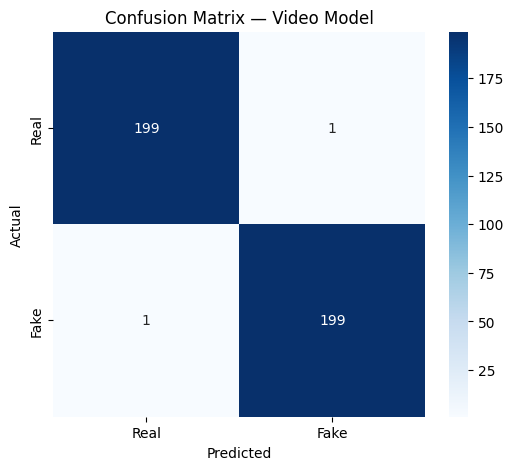

In [57]:
#STEP 2 — Confusion Matrix (Real vs Fake)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Video Model")
plt.show()


In [58]:
#STEP 3 — Classification Report (Precision, Recall, F1)
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds,
                            target_names=["Real", "Fake"]))


              precision    recall  f1-score   support

        Real       0.99      0.99      0.99       200
        Fake       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



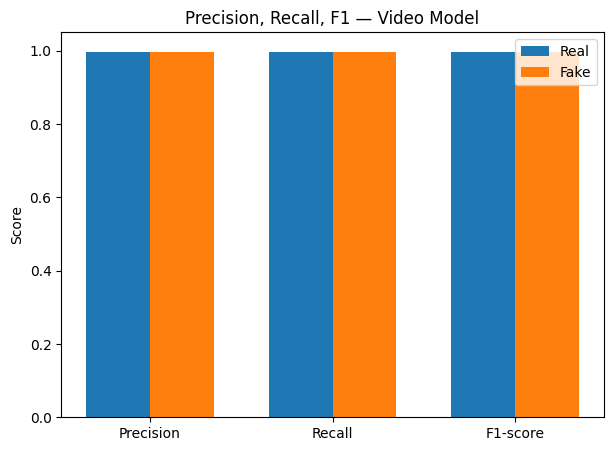

In [59]:
#STEP 4 — Precision / Recall / F1 bar chart
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

prec, rec, f1, support = precision_recall_fscore_support(
    all_labels,
    all_preds,
    labels=[0, 1]
)

metrics = ["Precision", "Recall", "F1-score"]
real_vals = [prec[0], rec[0], f1[0]]
fake_vals = [prec[1], rec[1], f1[1]]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, real_vals, width, label="Real")
plt.bar(x + width/2, fake_vals, width, label="Fake")
plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Precision, Recall, F1 — Video Model")
plt.legend()
plt.show()


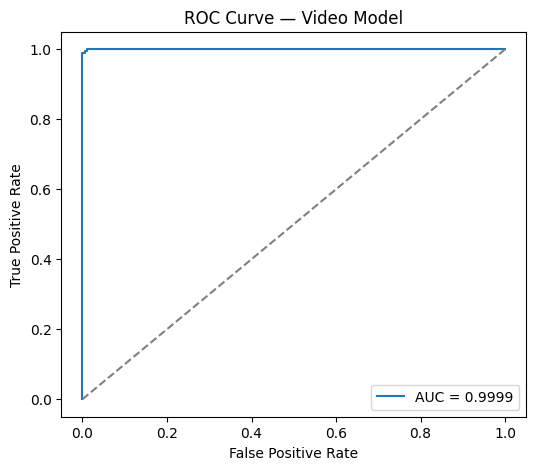

AUC Score: 0.999925


In [60]:
#STEP 5 — ROC Curve + AUC (Area Under the Curve)
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Video Model")
plt.legend()
plt.show()

print("AUC Score:", roc_auc)


In [63]:
#saving the model lator used for fusion
MODEL_PATH = "/kaggle/working/video_efficientnet_b0.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("Model saved at:", MODEL_PATH)


Model saved at: /kaggle/working/video_efficientnet_b0.pth
